# Diffusion Models
In this tutorial will dive into the inner workings of diffusion models, an extremely flexible class of generative models that have produced impressive samples from data types such as images.

We will here implement the Denoising Diffusion Probabilistic Models, DDPM, variant presented [here](https://arxiv.org/abs/2006.11239), but note that all diffusion formulations are closely related (have a look at [this awesome paper](https://arxiv.org/abs/2208.11970) to understand the connections between different generative models better)

In [1]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets, preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm 


Let's first sample some data, again from the two-dimensional two moons dataset, and standarize it

In [ ]:
noise = 0.05
x, _ = datasets.make_moons(n_samples=1_000, noise=noise)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

In [ ]:
def sample_moons(n_samples=1000, noise=noise):
    x, _ = datasets.make_moons(n_samples=n_samples, noise=noise)
    return torch.Tensor(scaler.transform(x).astype(np.float32))

The diffusion process consists of a Markov chain of latent variables that gradually adds noise to the data until the signal is destroyed, as shown in the image below. The job of the neural network is to reverse this process, such that we can generate samples from the data distribution starting from random noise.

![Diffusion](https://miro.medium.com/v2/resize:fit:1358/1*MLRitrnUdOy6rPtZfNwO4w.png)

Given that the forward diffusion process is a chain of conditional gaussians, we can easily get a sample $x_t$ at time $t$ given $x_0$. This simplifies greatly the training of diffusion models. To generate samples $x_t$ at time $t$ during training, we sample from the distribution 

$q(x_t|x_0) = \mathcal{N}(x_t|\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})I)$

which we write as

$x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{(1 - \bar{\alpha_t})} \epsilon$        

where $\epsilon$ is sampled from $\mathcal{N}(0,1)$ and $\bar{\alpha_t} = \prod_{s=1}^t \alpha_s$, where $\alpha_s = 1- \beta_t$. $\beta_t$ is known as the noise scheduler, as it controls the ammount of noise that is added to the image at time $t$. In this example we will use a simple linear noise scheduler, but commonly used schedulers are sigmoid or cosine, alternatively one might want to "learn" the noise scheduler.

Now we want to train a neural network with some trainable parameters, $\theta$ to model the reverse diffusion process that we parametrize as

$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1} | \mu_\theta(x_t, t), \Sigma_\theta(x_t,t))$

Usually, one sets $\Sigma_\theta(x_t,t) = \sigma_t^2 I = \beta_t I$, and models $\mu_\theta(x_t,t)$ as a neural network.

The optimal parameters are found by training the model to denoise the data

$L$

Interestingly, if we add some specific weigtings as a function of time to this loss function it becomes equivalent to a variational lower bound on the negative log likelihood. This means that by training the model to denoise, we are also maximizing the (approximate) likelihood  of the data. See [this paper](https://arxiv.org/abs/2303.00848) for a more nuanced discussion.




In [ ]:
from typing import Callable

class DDPM(nn.Module):
    def __init__(self, denoising_model: Callable, t: torch.Tensor, min_beta: float = 0.0001, max_beta: float =0.02):
        super().__init__()
        self.denoising_model = denoising_model
        self.t = t
        self.min_beta = min_beta 
        self.max_beta = max_beta 

    def beta_t(self,t: torch.Tensor)->torch.Tensor:
        # Variance schedule, determines how much noise is added
        # let's implement a simple linear schedule
        return self.min_beta + (self.max_beta - self.min_beta) * t / self.t[-1]

    def alpha_t(self,t: torch.Tensor)->torch.Tensor:
        # Over Equation 4 in arxiv:2006.11239
        return 1 - self.beta_t(t)

    def alpha_bar_t(self, t: torch.Tensor)->torch.Tensor:
        # Over Equation 4 in arxiv:2006.11239
        return torch.cumprod(self.alpha_t(self.t),dim=0)[t]
        
    def get_xt(self, x0: torch.Tensor, t: torch.Tensor, epsilon:torch.Tensor=None)->torch.Tensor:
        # Generate samples from the distribution given by Equation 4 in arxiv:2006.11239
        if epsilon is None:
            epsilon = torch.randn_like(x0)
        return torch.sqrt(self.alpha_bar_t(t)) * x0 + torch.sqrt(1 - self.alpha_bar_t(t)) * epsilon

    def get_predicted_noise(self, xt: torch.Tensor, t: torch.Tensor)->torch.Tensor:
        inputs = torch.concat([xt, t], dim=-1)
        eps_pred = self.denoising_model(inputs)
        return eps_pred

    def compute_loss(self, x0: torch.Tensor, t: torch.Tensor)->torch.Tensor:
        # Equation 14
        eps_true = torch.randn_like(x0)
        t = t.reshape(-1,1)
        xt = self.get_xt(x0, t, epsilon=eps_true)
        eps_pred = self.get_predicted_noise(xt, t)
        loss = torch.mean((eps_pred - eps_true) ** 2)
        return loss

    def sample(self, epsilon: torch.Tensor, return_trajectories=False,)->torch.Tensor:
        # Underneath Equation 11
        x_t = epsilon
        x_ts = []
        for t in torch.flip(self.t,[0]):
            t = torch.full((x_t.shape[0],1), t, device=x_t.device)
            eps_pred = self.get_predicted_noise(x_t, t)
            sigma_t = torch.sqrt((1 - self.alpha_bar_t(t)) / (1 - self.alpha_bar_t(t)) * self.beta_t(t))
            x_t = (
                1./(torch.sqrt(self.alpha_t(t))) * (x_t - (1 - self.alpha_t(t)) / (torch.sqrt(1 - self.alpha_bar_t(t))) * eps_pred) 
                + sigma_t * torch.randn_like(x_t)
            )
            x_ts.append(x_t)
        if return_trajectories:
            return x_ts
        return x_t


In [ ]:
denoising_model = nn.Sequential(
    nn.Linear(3, 128), # + time becomes 3
    nn.GELU(), 
    nn.Linear(128, 128), 
    nn.GELU(), 
    nn.Linear(128, 128), 
    nn.GELU(), 
    nn.Linear(128, 128), 
    nn.GELU(), 
    nn.Linear(128, 2), 
)

In [ ]:
n_time_steps = 50 
base_distribution = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
ddpm = DDPM(denoising_model=denoising_model,t=torch.arange(0, n_time_steps))

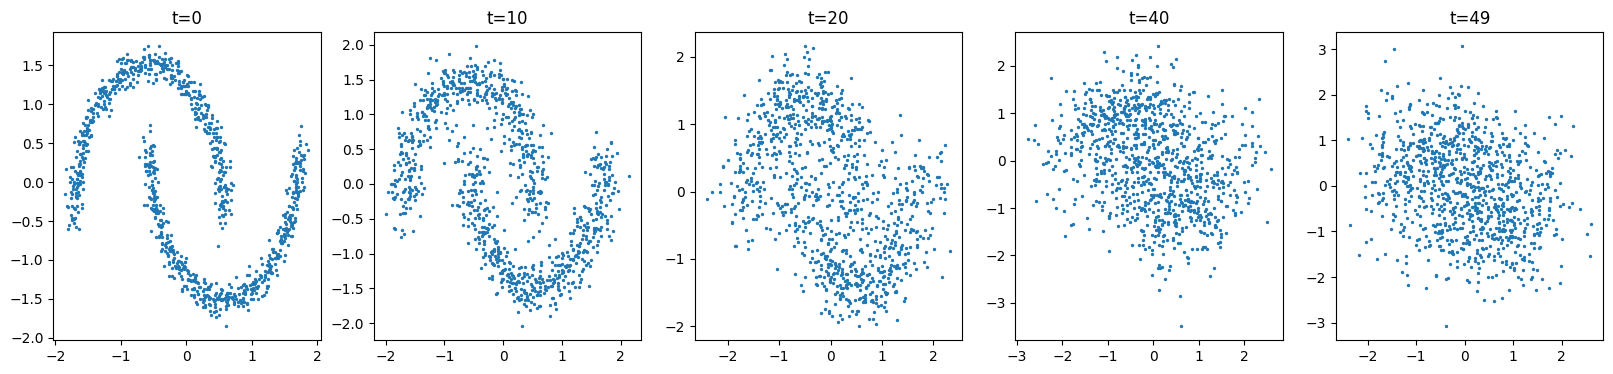

In [ ]:
# as opposed to the normalizing flow, the forward diffusion process (going from data to noise) is now fixed, not learned
fig, ax = plt.subplots(1,5, figsize=(20,4))
moons = sample_moons()
for i, t in enumerate([0, 10, 20, 40, 49]):
    noisy_moons = ddpm.get_xt(moons, t)
    ax[i].scatter(noisy_moons[:,0], noisy_moons[:,1], s=2)
    ax[i].set_title(f"t={t}")
# think about how different these trajectories are compared to those learned by the normalizing flow

Training:   0%|          | 0/50000 [00:00<?, ?it/s, loss=1.0603]

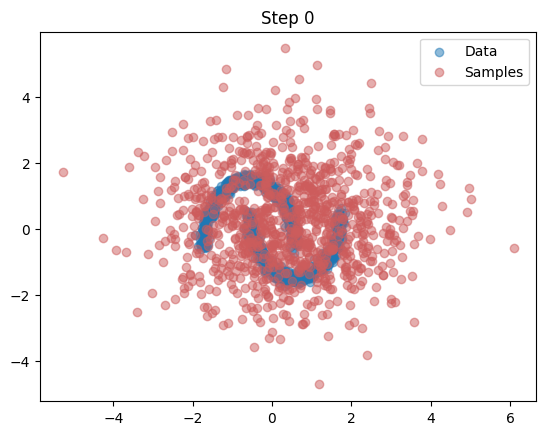

Training:   2%|▏         | 993/50000 [00:04<03:45, 217.24it/s, loss=0.7458]

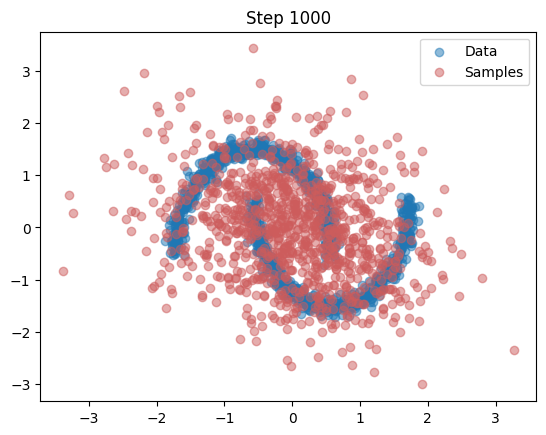

Training:   4%|▍         | 1995/50000 [00:09<03:36, 221.39it/s, loss=0.7632]

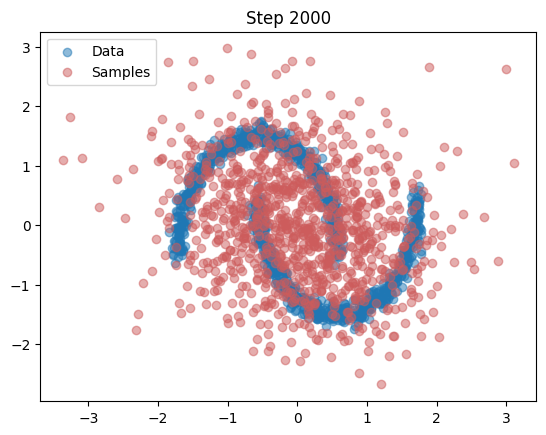

Training:   6%|▌         | 2990/50000 [00:14<03:31, 222.66it/s, loss=0.7743]

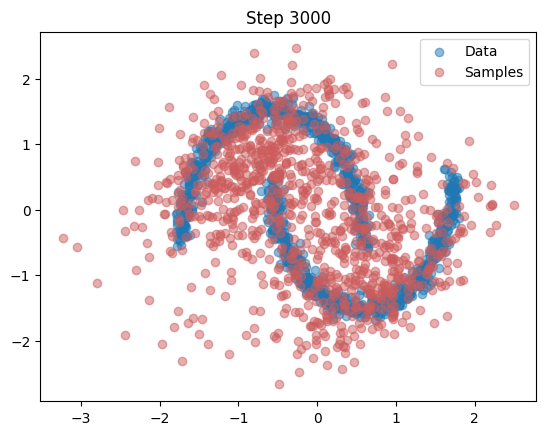

Training:   8%|▊         | 3987/50000 [00:19<03:23, 226.23it/s, loss=0.7400]

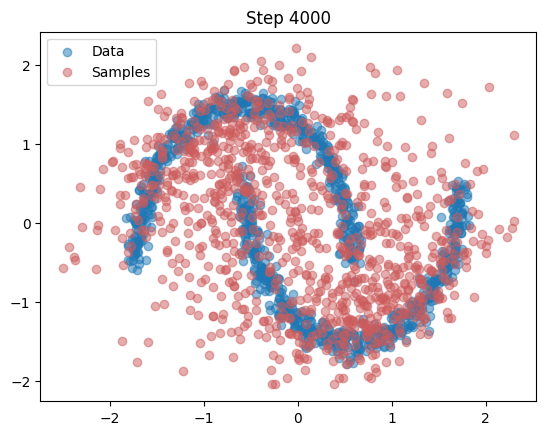

Training:  10%|▉         | 4982/50000 [00:23<03:15, 230.59it/s, loss=0.9060]

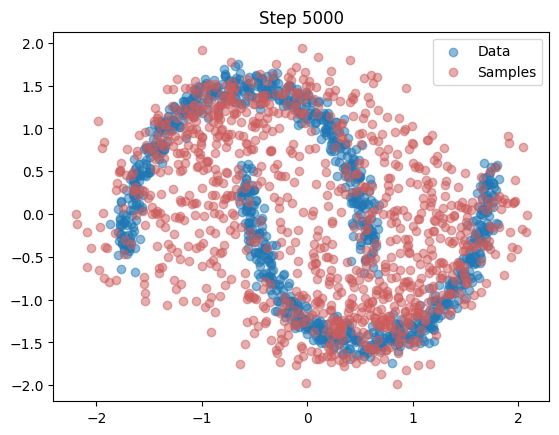

Training:  12%|█▏        | 5997/50000 [00:28<03:15, 225.33it/s, loss=0.5621]

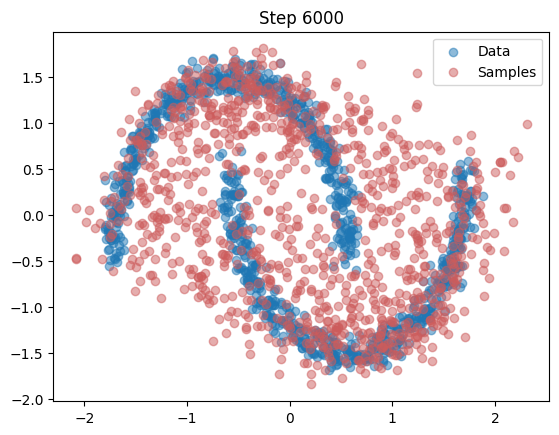

Training:  14%|█▍        | 6982/50000 [00:33<03:13, 222.48it/s, loss=0.7115]

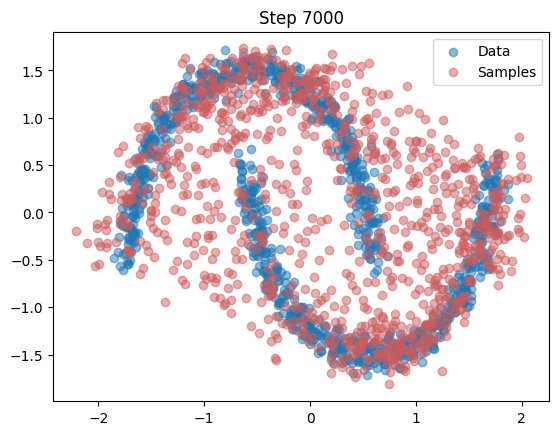

Training:  16%|█▌        | 7994/50000 [00:38<03:20, 209.99it/s, loss=0.6466]

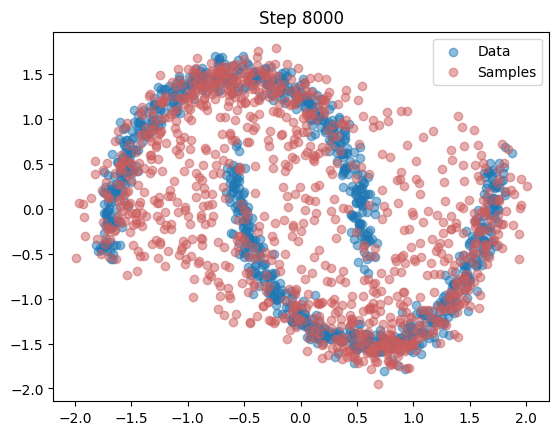

Training:  18%|█▊        | 8990/50000 [00:43<03:10, 215.75it/s, loss=0.7823]

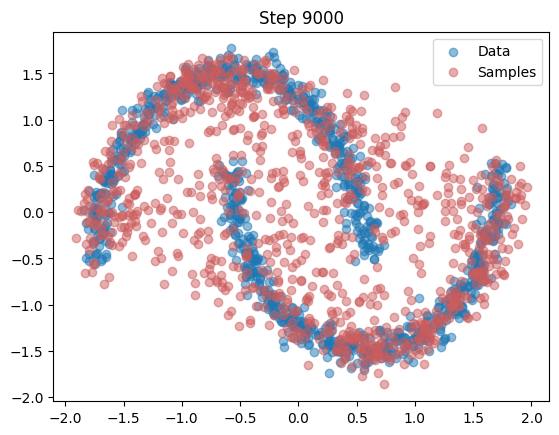

Training:  20%|█▉        | 9984/50000 [00:47<03:07, 213.49it/s, loss=0.6481]

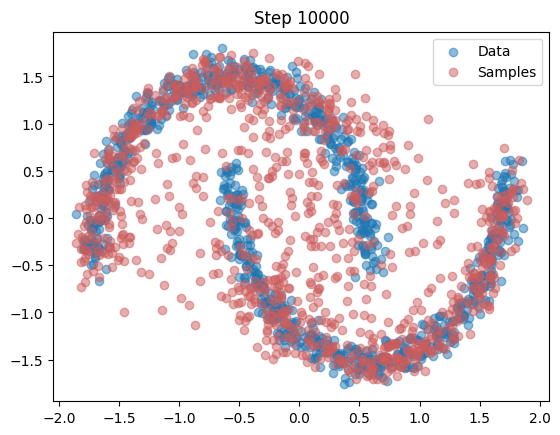

Training:  22%|██▏       | 10981/50000 [00:52<03:03, 213.11it/s, loss=0.7580]

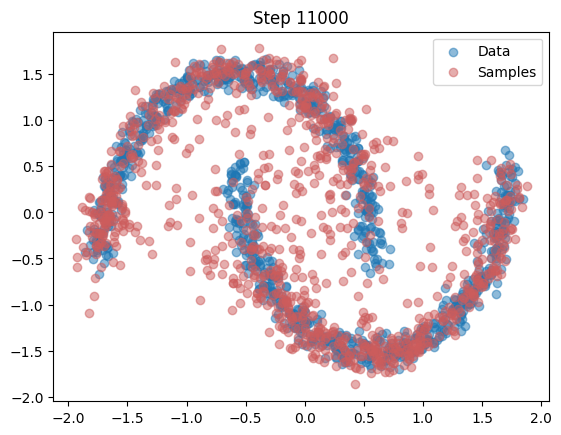

Training:  24%|██▍       | 11982/50000 [00:57<02:57, 214.78it/s, loss=0.5764]

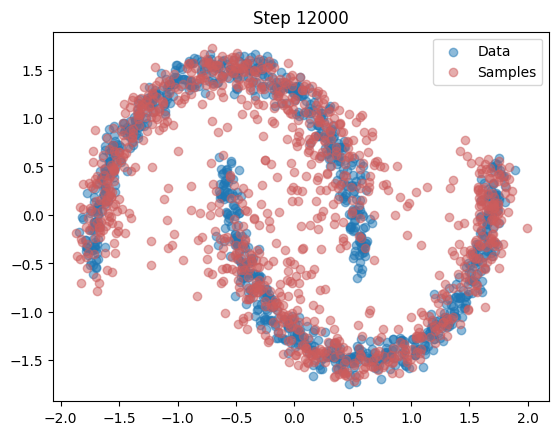

Training:  26%|██▌       | 12980/50000 [01:02<03:00, 205.42it/s, loss=0.6623]

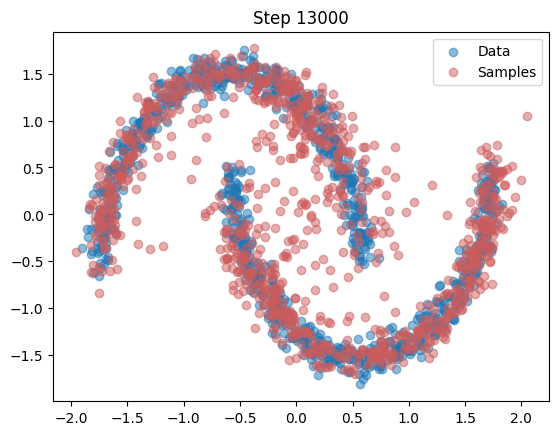

Training:  28%|██▊       | 13999/50000 [01:07<02:45, 217.25it/s, loss=0.6528]

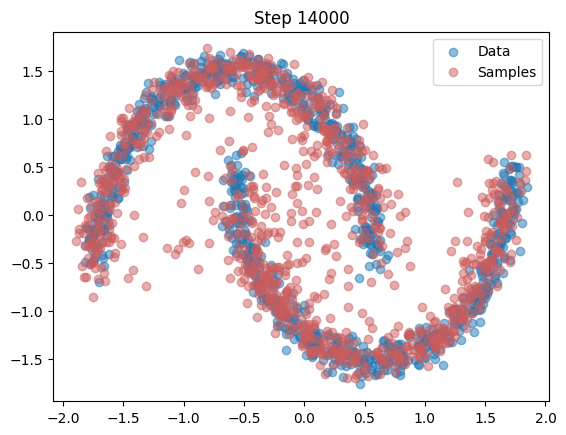

Training:  30%|███       | 15000/50000 [01:12<02:42, 215.35it/s, loss=0.7303]

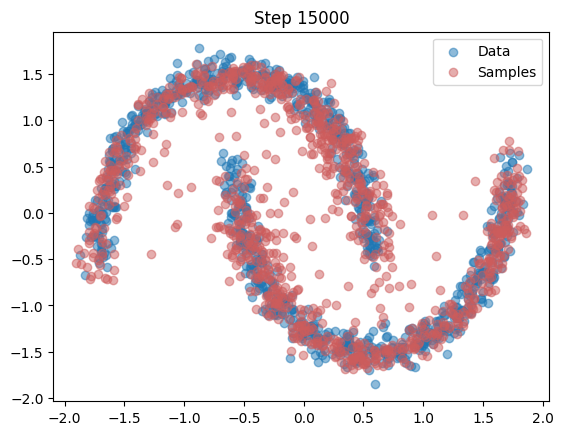

Training:  32%|███▏      | 15999/50000 [01:17<02:29, 227.25it/s, loss=0.7703]

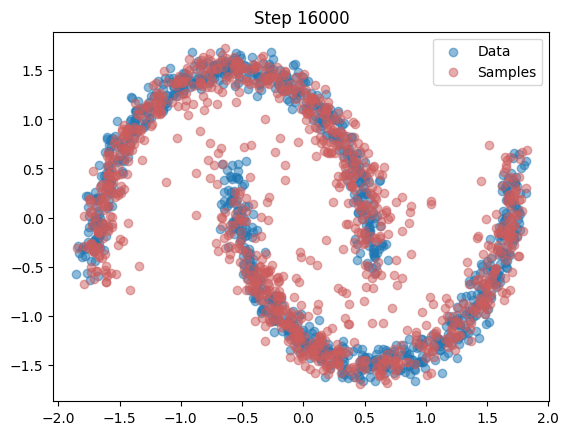

Training:  34%|███▍      | 16989/50000 [01:22<02:26, 224.68it/s, loss=0.6819]

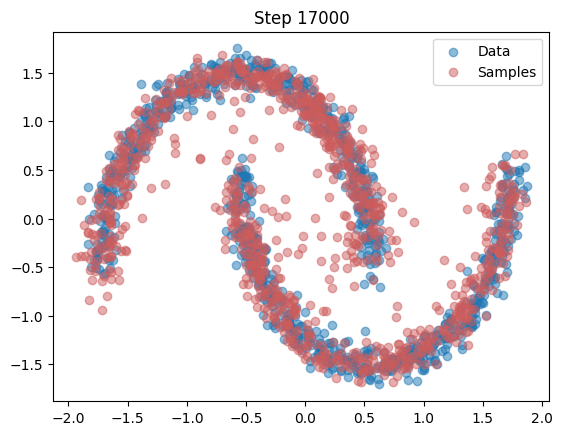

Training:  36%|███▌      | 17992/50000 [01:27<02:22, 223.95it/s, loss=0.7741]

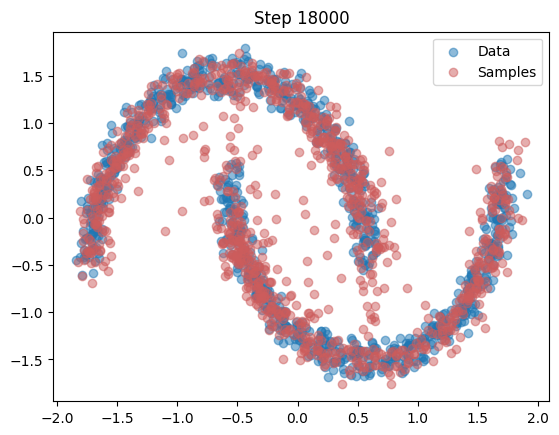

Training:  38%|███▊      | 18998/50000 [01:32<02:33, 202.28it/s, loss=0.6202]

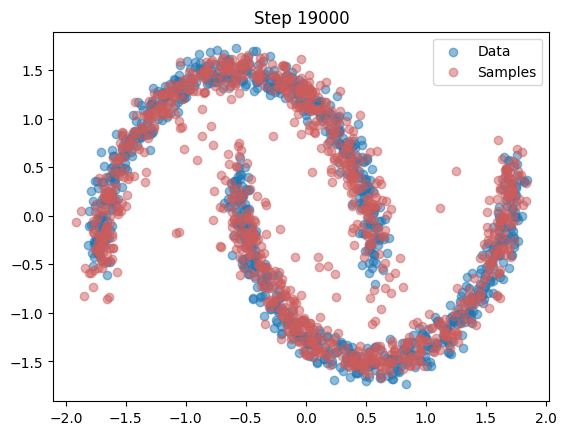

Training:  40%|███▉      | 19984/50000 [01:36<02:13, 225.09it/s, loss=0.6476]

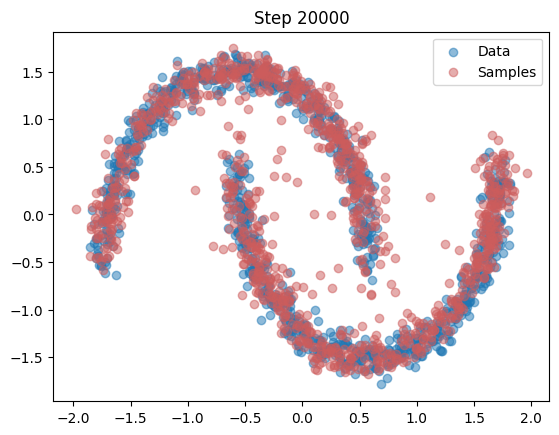

Training:  42%|████▏     | 20996/50000 [01:41<02:07, 227.34it/s, loss=0.7491]

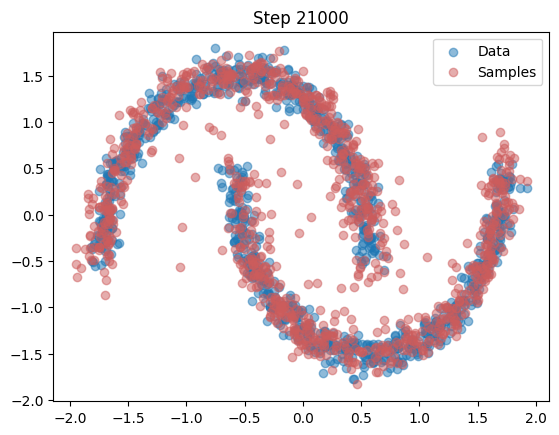

Training:  44%|████▍     | 21993/50000 [01:46<02:01, 231.35it/s, loss=0.7265]

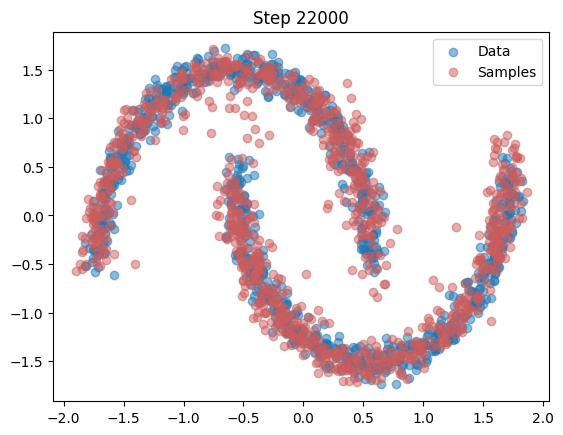

Training:  46%|████▌     | 22995/50000 [01:50<01:58, 227.83it/s, loss=0.7974]

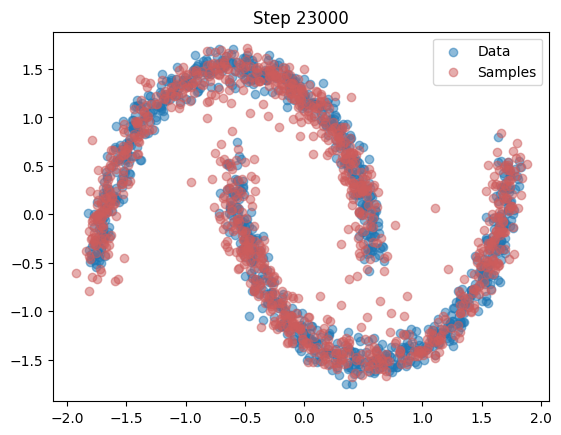

Training:  48%|████▊     | 23991/50000 [01:55<01:53, 228.21it/s, loss=0.5644]

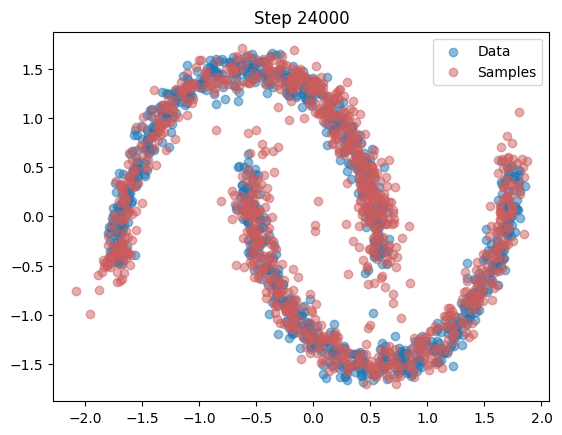

Training:  50%|████▉     | 24993/50000 [02:00<01:50, 226.11it/s, loss=0.6887]

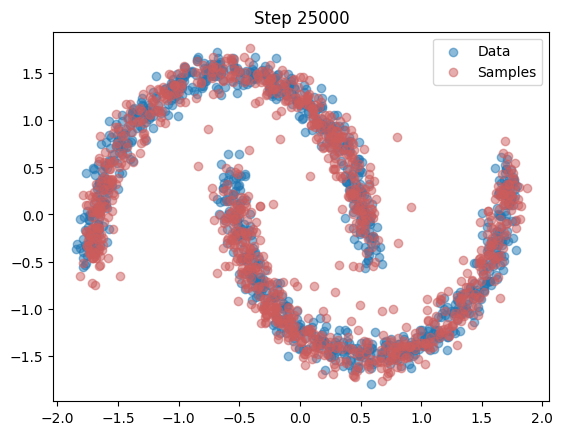

Training:  52%|█████▏    | 25997/50000 [02:05<01:48, 221.44it/s, loss=0.5521]

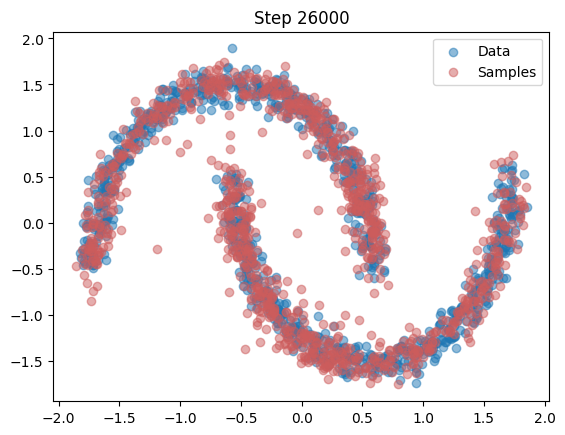

Training:  54%|█████▍    | 27000/50000 [02:09<01:46, 216.79it/s, loss=0.5492]

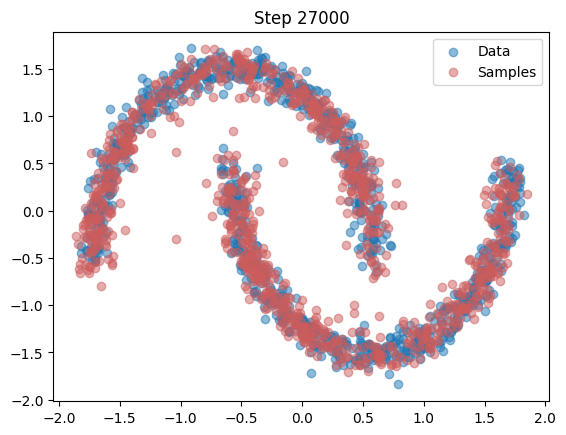

Training:  56%|█████▌    | 27980/50000 [02:14<01:39, 220.22it/s, loss=0.6588]

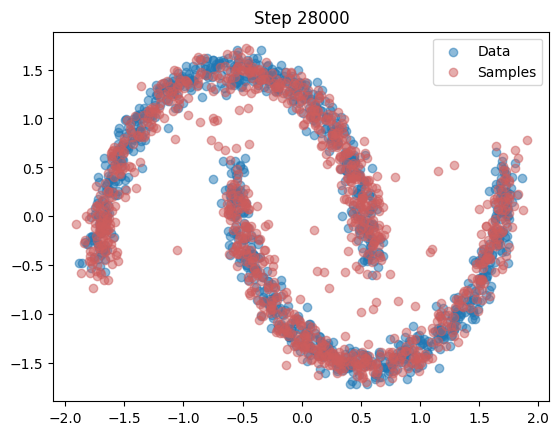

Training:  58%|█████▊    | 28980/50000 [02:19<01:37, 216.15it/s, loss=0.5898]

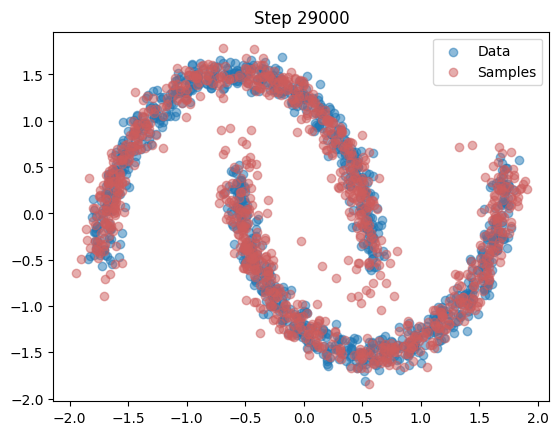

Training:  60%|█████▉    | 29982/50000 [02:24<01:32, 217.26it/s, loss=0.5647]

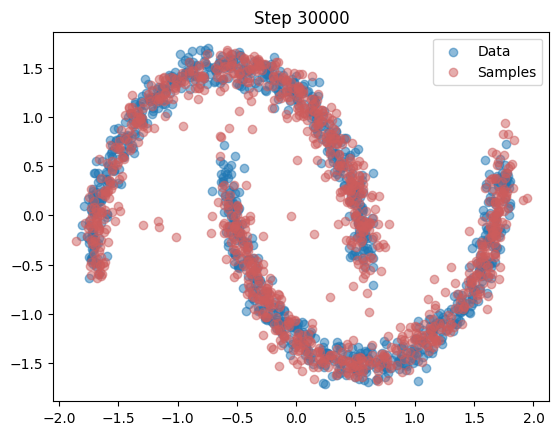

Training:  62%|██████▏   | 30989/50000 [02:29<01:31, 208.49it/s, loss=0.7214]

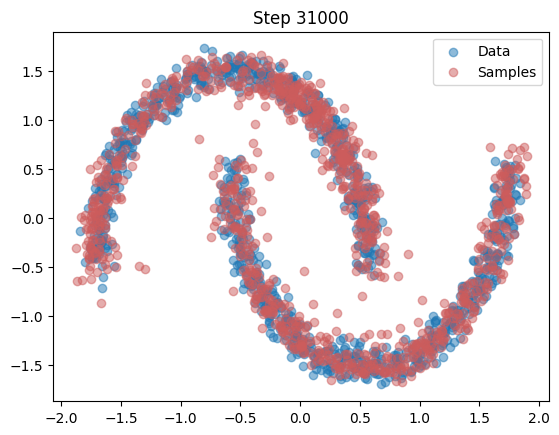

Training:  64%|██████▍   | 31981/50000 [02:34<01:22, 218.74it/s, loss=0.5305]

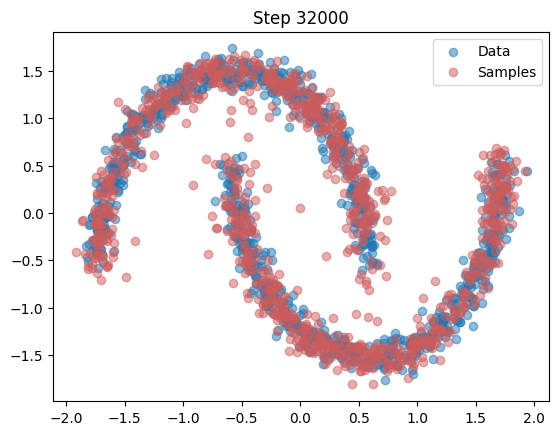

Training:  66%|██████▌   | 32986/50000 [02:39<01:16, 223.34it/s, loss=0.6368]

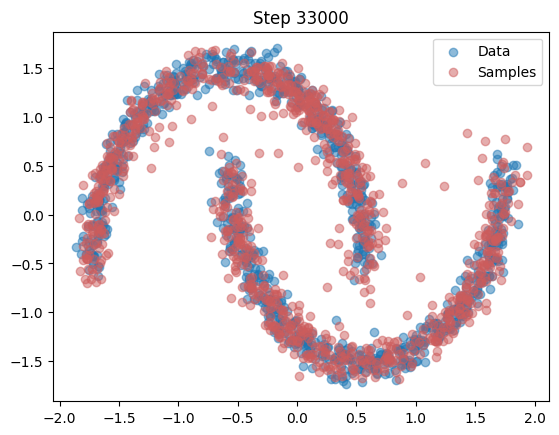

Training:  68%|██████▊   | 33989/50000 [02:43<01:12, 220.45it/s, loss=0.6661]

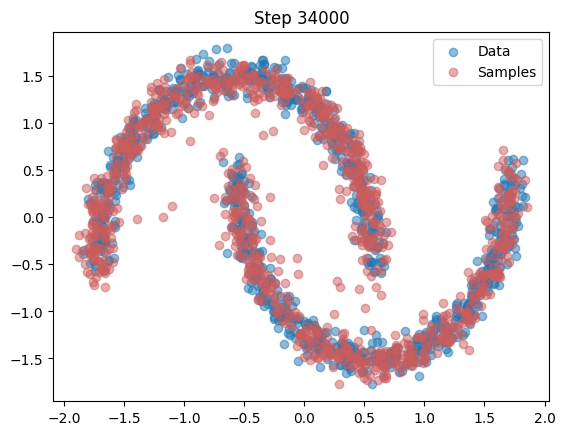

Training:  70%|██████▉   | 34995/50000 [02:48<01:07, 222.39it/s, loss=0.5840]

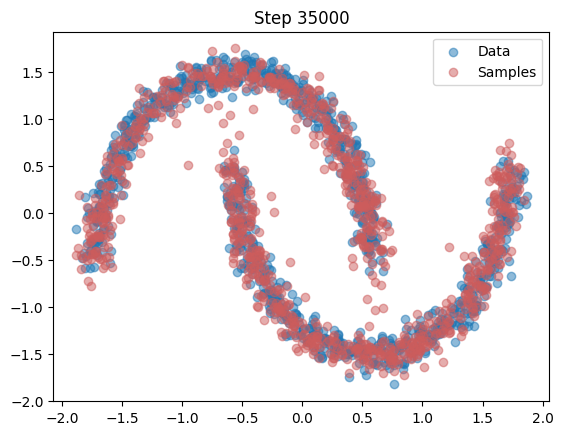

Training:  72%|███████▏  | 35985/50000 [02:53<01:08, 203.89it/s, loss=0.7003]

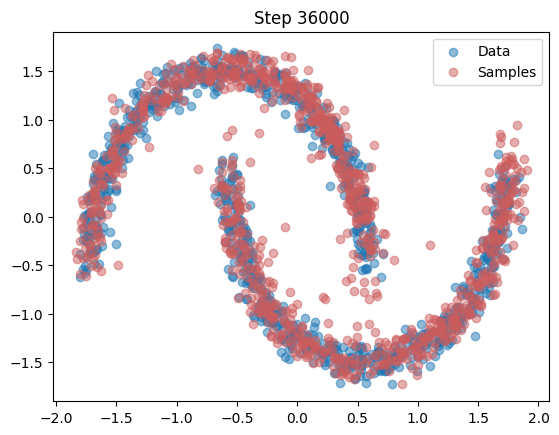

Training:  74%|███████▍  | 36992/50000 [02:58<01:00, 215.20it/s, loss=0.5579]

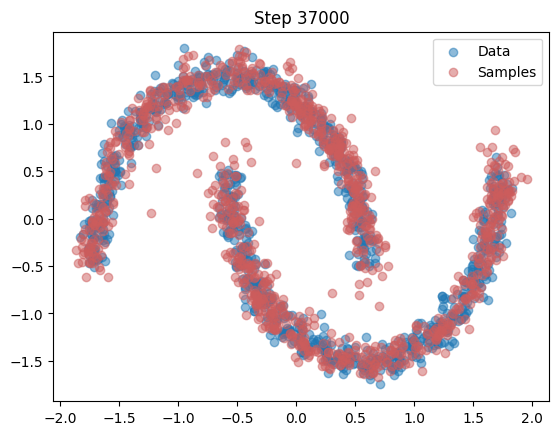

Training:  76%|███████▌  | 37993/50000 [03:03<00:54, 219.98it/s, loss=0.5729]

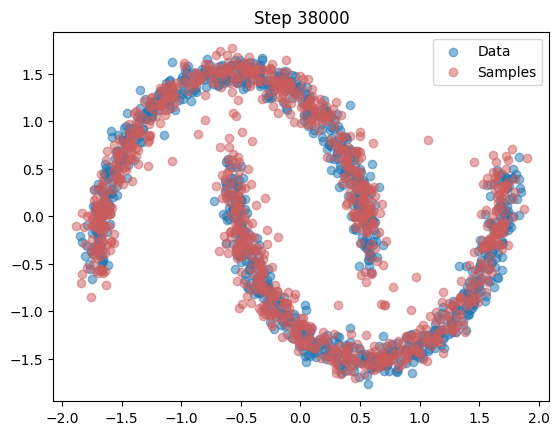

Training:  78%|███████▊  | 39000/50000 [03:08<00:53, 206.07it/s, loss=0.7361]

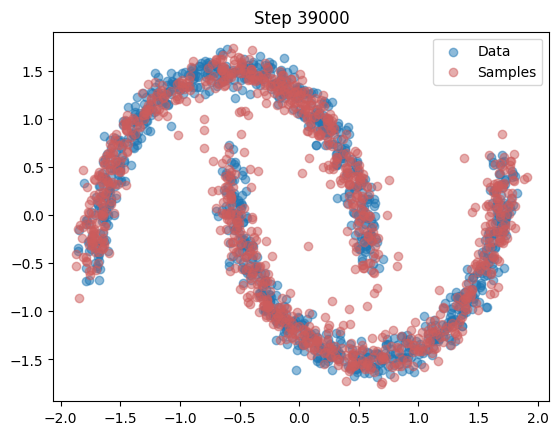

Training:  80%|███████▉  | 39987/50000 [03:13<00:47, 209.44it/s, loss=0.6543]

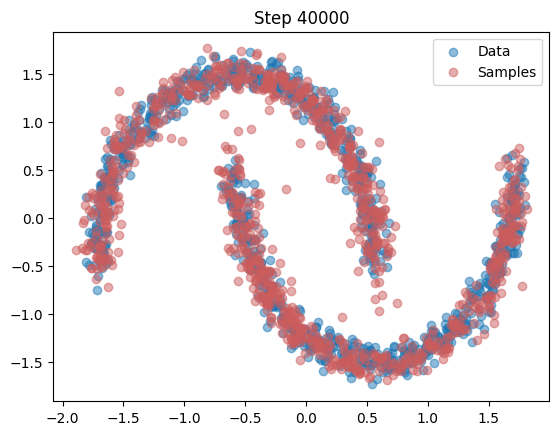

Training:  82%|████████▏ | 40980/50000 [03:18<00:40, 221.55it/s, loss=0.5856]

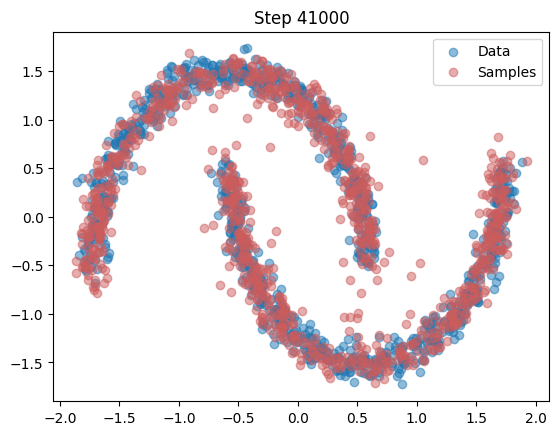

Training:  84%|████████▍ | 41988/50000 [03:23<00:36, 218.47it/s, loss=0.7226]

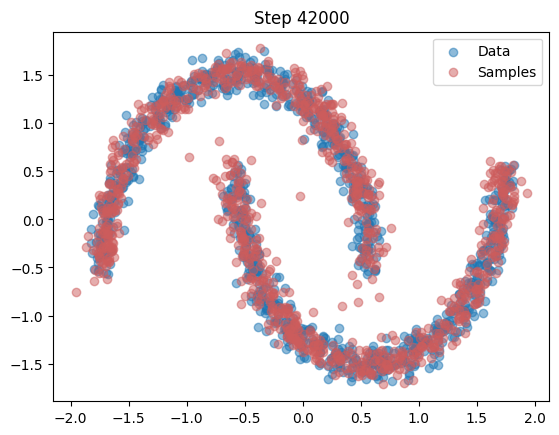

Training:  86%|████████▌ | 42981/50000 [03:28<00:33, 211.68it/s, loss=0.7340]

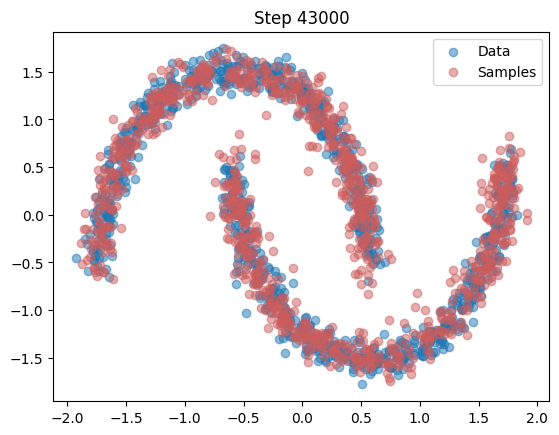

Training:  88%|████████▊ | 43998/50000 [03:33<00:30, 195.12it/s, loss=0.7130]

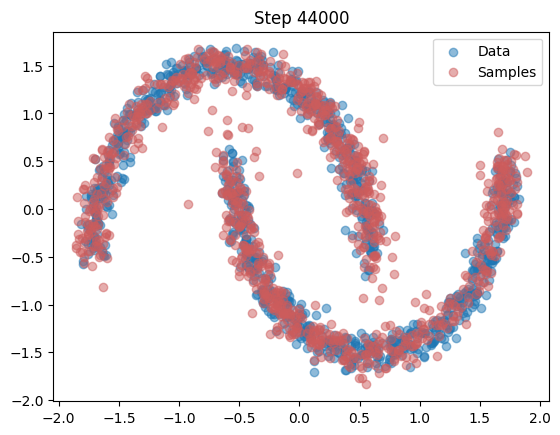

Training:  90%|████████▉ | 44979/50000 [03:38<00:24, 209.14it/s, loss=0.5973]

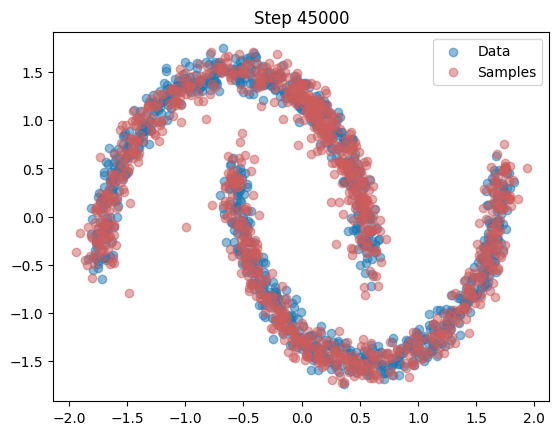

Training:  92%|█████████▏| 45987/50000 [03:43<00:18, 221.44it/s, loss=0.5814]

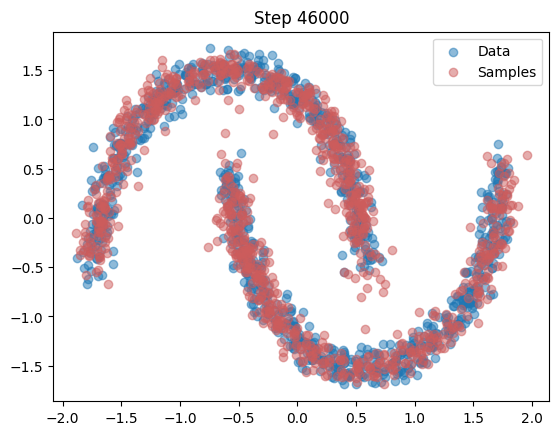

Training:  94%|█████████▍| 46983/50000 [03:48<00:14, 214.55it/s, loss=0.7103]

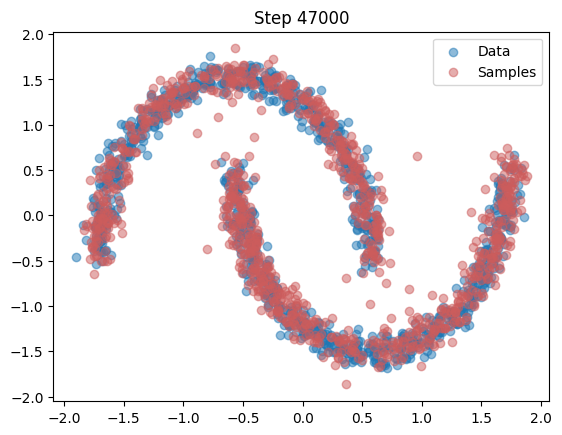

Training:  96%|█████████▌| 47988/50000 [03:53<00:09, 220.91it/s, loss=0.7649]

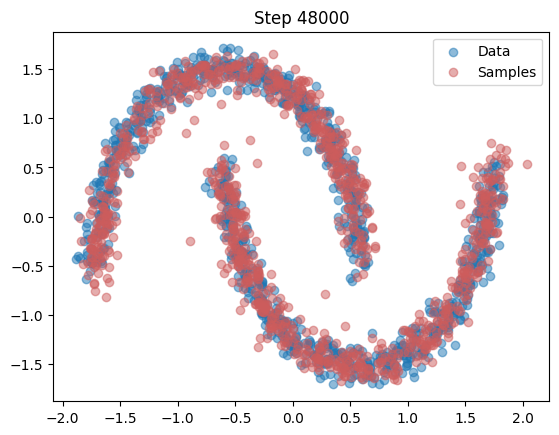

Training:  98%|█████████▊| 48994/50000 [03:58<00:04, 213.87it/s, loss=0.5871]

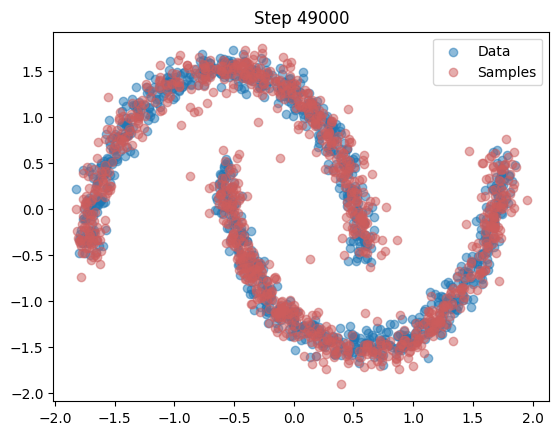

Training: 100%|██████████| 50000/50000 [04:03<00:00, 205.43it/s, loss=0.5237]


In [ ]:
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)
n_batch = 128
n_steps = 50_000
progress_bar = tqdm(range(n_steps), desc='Training')

losses = []
for step in progress_bar:

    noisy_moons = sample_moons(n_samples=n_batch, noise=noise)
    t = torch.randint(0, n_time_steps, (n_batch,))
    loss = ddpm.compute_loss(noisy_moons, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    progress_bar.set_postfix(loss=f'{loss.item():.4f}')


    optimizer.step()
    losses.append(loss.item())
    
    if step % 1_000 == 0:
        n_samples = 1_000
        epsilon = base_distribution.sample((n_samples,))
        sampled_moons = ddpm.sample(epsilon).detach().numpy()
        noisy_moons = sample_moons(n_samples=n_samples, noise=noise)
        plt.scatter(noisy_moons[:,0], noisy_moons[:,1],alpha=0.5, label='Data')
        plt.scatter(sampled_moons[:,0], sampled_moons[:,1],alpha=0.5, label='Samples', color='indianred')
        plt.legend()
        plt.title(f'Step {step}')
        plt.show()

Text(0, 0.5, 'Loss')

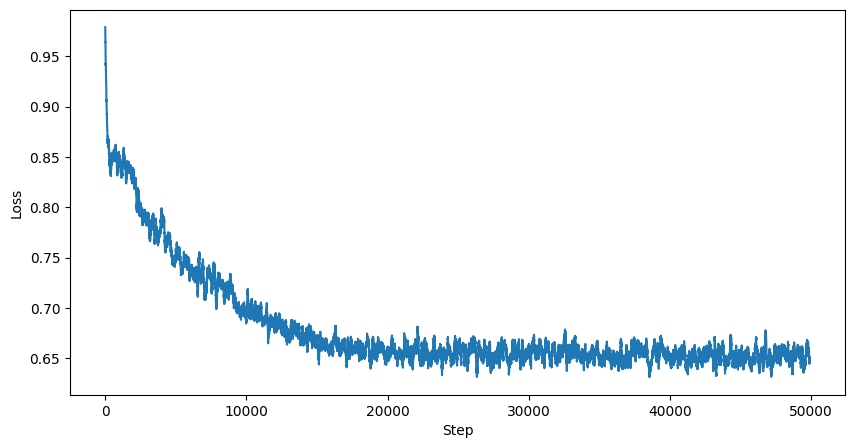

In [ ]:
def moving_average(data, window_size):
    """Calculate the moving average of a given data array."""
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

# Assuming `losses` is a list of your recorded losses
window_size = 100  # Define the size of the window for moving average
ma_losses = moving_average(np.array(losses), window_size)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(ma_losses,)
plt.xlabel('Step')
plt.ylabel('Loss')

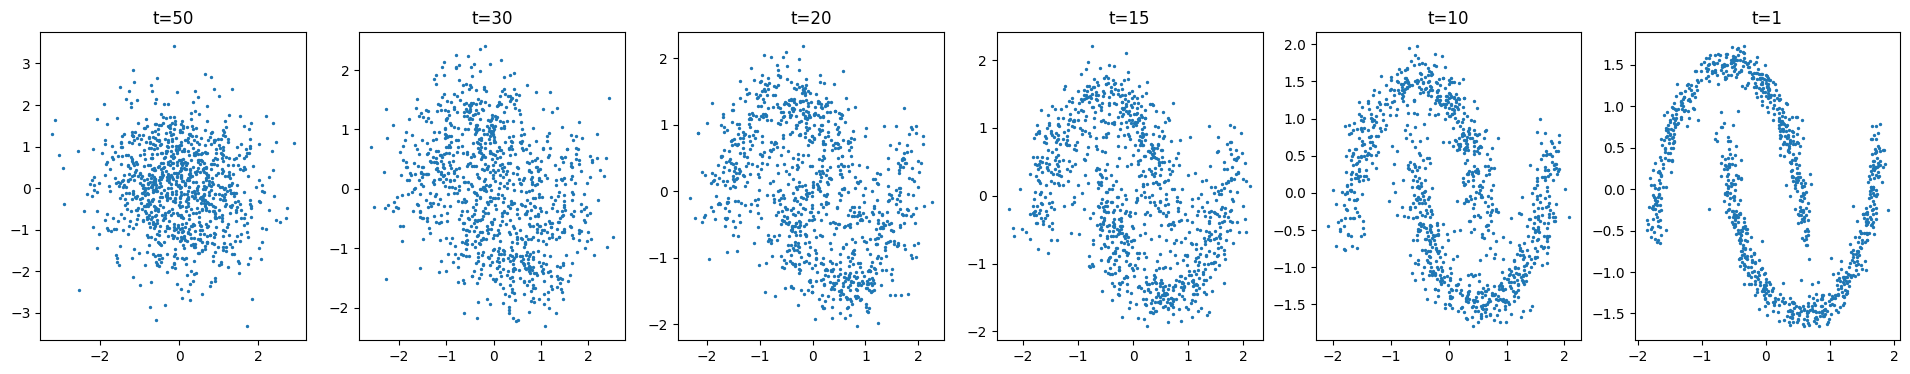

In [ ]:
# Let's look at the reverse diffusion process
fig, ax = plt.subplots(1,6, figsize=(24,4))
epsilon = base_distribution.sample((1000,))
sampled_moons = ddpm.sample(epsilon, return_trajectories=True)

for i, t in enumerate([0, 20, 30, 35, 40, 49]):
    moons = sampled_moons[t].detach().numpy()
    ax[i].scatter(moons[:,0], moons[:,1], s=2)
    ax[i].set_title(f"t={n_time_steps-t}")


In [ ]:
# under construction: generating DESI spectra and DESI images